## Analyze Type 1 & Type 2 Diabetes Patients

Setup the imports.

In [1]:
from pyqe import *

Always start with creating a query object. 

Apart from creating Query object, it does the following that are required for setting up your profile:
- Ask for username and password for login

In [2]:
# Always begin your script by creating Query object
total_patients_query = Query('Total_Participants')

Use get_study_list() method to fetch all available studies that you have access to.

Use set_study() method to select a study that you are interested in (by passing the study ID).

In [3]:
total_patients_query.get_study_list()

# any STUDY_ID from above list
total_patients_query.set_study('b34f1da5-d9a8-442d-9589-f147ac0db194') 

07-Apr-2022 06:26:00 - INFO - Token is expired. Refreshing token...
07-Apr-2022 06:26:03 - INFO - Refresh token successful


Study Name - Study Id
(1) ALP TEST STUDY (staging) - 52144b69-5525-4a3a-85dd-0857bd1f23c1
(2) Accept - a0cd02ce-6d1b-49f3-bc0e-14590c0249b3
(3) Broad consent - 1b29380e-dfd2-4ada-b7cc-a6d8575a631d
(4) ECOV - 686d3b9b-b8fd-46ba-9e25-af48c027bb55
(5) FeMFit - 3506d0d0-0c67-4983-b9ce-b4d0ea8daeac
(6) Smart4Health (Data Donation) - c834c651-a886-470f-b73b-9d8766845c07
(7) Synpuf1k - b34f1da5-d9a8-442d-9589-f147ac0db194
(8) VaccineEffectiveness - e2ff06fc-18da-49b7-826e-d198c239ac6a


Similar to above step, use get_config_list() method to fetch all available configurations corresponding to the study.

Use set_study_config() method to select a config (by passing the config ID).

In [4]:
total_patients_query.get_config_list()

# any CONFIG_ID from above list
total_patients_query.set_study_config('92d7c6f8-3118-4256-ab22-f2f7fd19d4e7') 

Assignment Name, Config Name - Config Id
(1) DEFAULT-ASSIGNMENT, OMOP_GDM_PA_CONF - 92d7c6f8-3118-4256-ab22-f2f7fd19d4e7
(2) GDM_DM_Config, GDM_PA_CONF - 903012b3-7c7b-4c96-a5b9-af38914b04b7
(3) OMOP GDM Config, MRI_TEST_PA_CONF - 4cd7f5ba-5405-437a-90c2-3165dc53f484


In [5]:
patients = Person.Patient()

constraint_age_greater_than_60_years = Constraint()
constraint_age_greater_than_60_years.add(Expression(ComparisonOperator.MORE_THAN_EQUAL, 60))

constraint_age_lesser_than_90_years = Constraint()
constraint_age_lesser_than_90_years.add(Expression(ComparisonOperator.LESS_THAN_EQUAL, 90))

patients.add_age([constraint_age_greater_than_60_years])
patients.add_age([constraint_age_lesser_than_90_years])

In [6]:
exclude_Death = Interactions.Death("Death", CardType.EXCLUDED)

In [7]:
# Condition Concept IDs for Diabetes Mellitus 2

diabetes2_conditionOcc = Interactions.ConditionOccurrence("Type 2 Diabetes condition")
diabetes2_condition_concepts = ConceptSet(
                           'Conditions',
                            Domain.CONDITION, 
                           ['44054006', '8801005', '190331003', '421326000', '443694000', '422014003', '421326000']) 

diabetes2_conditionOcc.add_concept_set(diabetes2_condition_concepts)

In [8]:
# Diabetes type 1

diabetes1_conditionOcc = Interactions.ConditionOccurrence("Type 1 Diabetes condition")
diabetes1_condition_concepts = ConceptSet(
                           'Conditions',
                            Domain.CONDITION, 
                           ['201254', '318712', '435216', '40484648', '200687', '377821']) 
diabetes1_conditionOcc.add_concept_set(diabetes1_condition_concepts)

In [9]:
patient_criteriagroup = CriteriaGroup(MatchCriteria.ALL, [patients, exclude_Death])

diabetes_criteriagroup = CriteriaGroup(
                        MatchCriteria.ANY, [diabetes1_conditionOcc, diabetes2_conditionOcc])

patient_criteriagroup.add_exclusive_group(diabetes_criteriagroup)
total_patients_query.add_criteria_group(patient_criteriagroup)

With the query object created in the previous step, call the method get_patient_count_filter() to create a request object.

In [10]:
# create Result object and fetch the patient count
total_patients_req = total_patients_query.get_patient_count_filter()

Further create a Result class object (that does magic).

In our case, get_patient_count() method is called by passing the request object created above.

Returned result will be the patient count as integer value.

In [11]:
total_patients = Result().get_patient_count(total_patients_req)
print(f'\nTotal participants: {total_patients}')


Total participants: 440


In [12]:
# Generate Request for Dataframe cohort
request_df = total_patients_query.get_dataframe_cohort([],'Patient')

# Get Patient Dataframe. Select (1) Patient
patient_df = Result().download_dataframe(request_df)

In [13]:
# Peek Into the Patient Demographics Data
selective_patient_df = patient_df[['pid', 'gender', 'dateofbirth', 'ethnicity', 'race', 'state']]

selective_patient_df.head(10)

,pid,gender,dateofbirth,ethnicity,race,state
0,2,MALE,1943-01-01,Not Hispanic or Latino,White,PA
1,3,FEMALE,1936-09-01,Not Hispanic or Latino,White,PA
2,4,MALE,1941-06-01,Hispanic or Latino,No matching concept,CO
3,5,MALE,1936-08-01,Not Hispanic or Latino,White,WI
4,6,MALE,1943-10-01,Not Hispanic or Latino,Black or African American,NY
5,8,MALE,1935-09-01,Not Hispanic or Latino,White,MN
6,11,FEMALE,1934-02-01,Not Hispanic or Latino,White,IN
7,13,FEMALE,1936-07-01,Not Hispanic or Latino,White,RI
8,14,MALE,1934-05-01,Not Hispanic or Latino,White,IL
9,15,FEMALE,1936-03-01,Not Hispanic or Latino,White,ID


In [14]:
# Generate Request for Dataframe cohort
condOcc_request_df = total_patients_query.get_dataframe_cohort([],'ConditionOccurrence')

# Get Patient Dataframe. Select (1) Patient
condOcc_df = Result().download_dataframe(condOcc_request_df)

In [15]:
selective_condOcc_df = condOcc_df[['conditionoccurrenceid', 'pid', 'conditionname','conditiontype','startdate','enddate','condconceptcode', 'conditionconceptid']]
selective_condOcc_df.head(10)

,conditionoccurrenceid,pid,conditionname,conditiontype,startdate,enddate,condconceptcode,conditionconceptid
0,133755,1001,Fever,Outpatient header - 1st position,2010-03-05,2010-03-05,386661006,437663
1,133756,1001,Fever,Outpatient header - 1st position,2010-03-05,2010-03-05,386661006,437663
2,133742,1001,Osteoporosis,Outpatient header - 1st position,2010-02-11,2010-02-11,64859006,80502
3,133741,1001,Osteoporosis,Outpatient header - 1st position,2010-02-11,2010-02-11,64859006,80502
4,133731,1001,Disorder of nervous system due to type 2 diabe...,Outpatient header - 1st position,2009-10-10,2009-10-10,421326000,376065
5,133729,1001,Electroencephalogram abnormal,Outpatient header - 1st position,2009-10-10,2009-10-10,274521009,4168553
6,133732,1001,Plantar nerve lesion,Outpatient header - 1st position,2009-10-10,2009-10-10,193148004,138148
7,133734,1001,Plantar nerve lesion,Outpatient header - 1st position,2009-10-10,2009-10-10,193148004,138148
8,133730,1001,Pain in limb,Outpatient header - 1st position,2009-10-10,2009-10-10,90834002,138525
9,133733,1001,Plantar nerve lesion,Outpatient header - 1st position,2009-10-10,2009-10-10,193148004,138148


In [16]:
specific_columns = total_patients_query.get_entities_dataframe_cohort(['patient.attributes.pid','patient.attributes.Gender', 
                                                                       'patient.attributes.dateOfBirth',
                                                                       'patient.interactions.conditionoccurrence.attributes.conditionname', 
                                                                       'patient.interactions.conditionoccurrence.attributes.conditiontype',
                                                                       'patient.interactions.visit.attributes.visitname',
                                                                       'patient.interactions.proc.attributes.procname'])

In [17]:
from IPython.display import display, HTML

def printer2(title: str = "", d: dict = {}):
    print(f"Entities with {title}\n")
    r = Result().download_all_entities_dataframe(d)
    for entity_name in r.keys():
        print(f"{entity_name}: {len(r[entity_name])} rows\n")
        display(HTML(r[entity_name][:10].to_html()))

In [18]:
printer2("Specific columns", specific_columns)

Entities with Specific columns

Patient: 440 rows



,gender,dateofbirth,pid
0,MALE,1943-01-01,2
1,FEMALE,1936-09-01,3
2,MALE,1941-06-01,4
3,MALE,1936-08-01,5
4,MALE,1943-10-01,6
5,MALE,1935-09-01,8
6,FEMALE,1934-02-01,11
7,FEMALE,1936-07-01,13
8,MALE,1934-05-01,14
9,FEMALE,1936-03-01,15


Death: 0 rows



""


ConditionOccurrence: 48908 rows



,pid,conditionname,conditiontype
0,1001,Fever,Outpatient header - 1st position
1,1001,Osteoporosis,Outpatient header - 1st position
2,1001,Disorder of nervous system due to type 2 diabetes mellitus,Outpatient header - 1st position
3,1001,Electroencephalogram abnormal,Outpatient header - 1st position
4,1001,Plantar nerve lesion,Outpatient header - 1st position
5,1001,Pain in limb,Outpatient header - 1st position
6,1001,Retinal vascular occlusion,Outpatient header - 1st position
7,1001,Urinary tract infectious disease,Outpatient header - 1st position
8,1001,Urethral syndrome,Outpatient header - 1st position
9,1001,Allergic rhinitis,Outpatient header - 1st position


visit: 1046 rows



,pid,visitname
0,1001,No matching concept
1,1002,No matching concept
2,1002,Outpatient Visit
3,1002,Inpatient Visit
4,1004,No matching concept
5,1004,Outpatient Visit
6,1007,No matching concept
7,1007,Outpatient Visit
8,1007,Inpatient Visit
9,101,Outpatient Visit


proc: 18915 rows



,pid,procname
0,1001,NaN
1,1001,"Removal of implanted devices from bone, humerus"
2,1001,Incision of chest wall and pleura
3,1001,Preoperative cardiovascular examination
4,1001,Other repair of urethra
5,1001,"Bone graft, patella"
6,1001,Other intrathoracic esophagoenterostomy
7,1001,Pre-surgery evaluation
8,1001,Administration of influenza virus vaccine
9,1002,Other repair of urethra


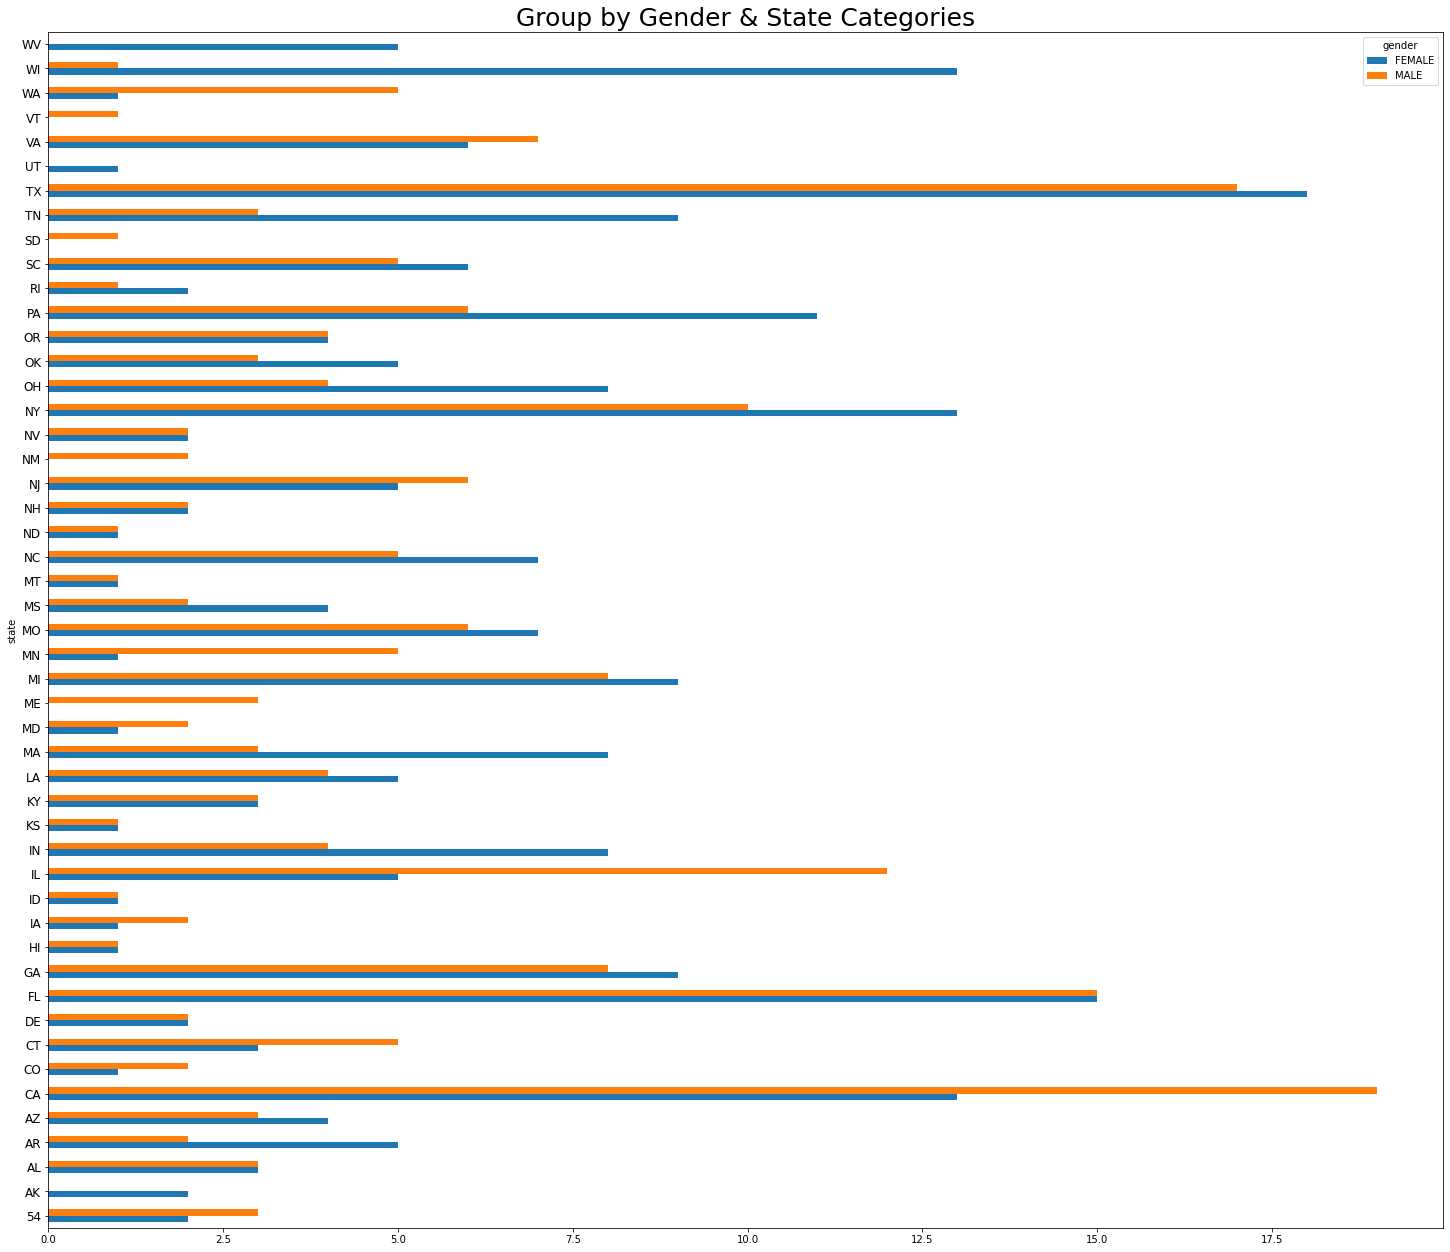

In [19]:
import pandas as pd

barh_table = pd.crosstab(selective_patient_df.state, selective_patient_df.gender)
ax = barh_table.plot.barh(figsize=(25,22), title='Group by Gender & State Categories')
ax.yaxis.set_tick_params(labelsize='large')
ax.title.set_size(25)

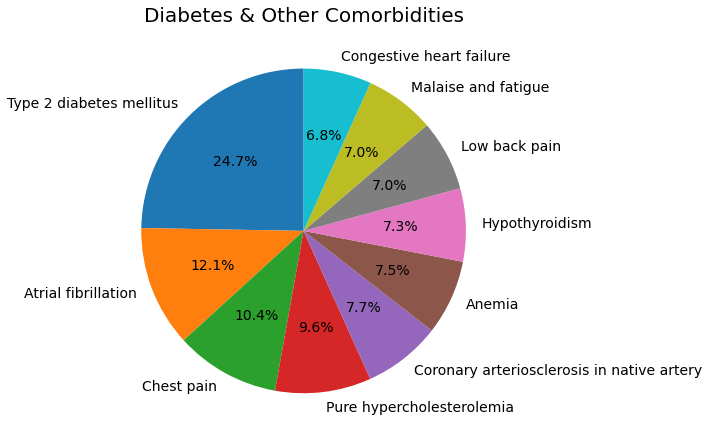

In [20]:
import matplotlib.pyplot as plt

# Group Data by Conditions
co_mini_df = condOcc_df[['conditionname', 'pid']]
co_group_df = co_mini_df.groupby(['conditionname']).count()
co_group_df.rename(columns = {'pid':'count'}, inplace = True)

# Sort & Pick the top 10 conditions
co_group_df.sort_values(by=['count'], inplace=True, ascending=False)
co_group_df_top10 = co_group_df.head(10)
plt.figure(figsize=(16,8))

# plot pie chart
ax1 = plt.subplot(121, aspect='equal')
co_group_df_top10.plot(kind='pie', y = 'count', ax=ax1, autopct='%1.1f%%', 
 startangle=90, shadow=False, legend = False, fontsize=14)

plt.title('Diabetes & Other Comorbidities', fontdict={'fontsize':20})
plt.axis('off')
plt.show()

## Null Hypothesis:
    
### Coronary Disorders and Gender are independent of each other.

In [21]:
import pandas as pd
import numpy as np

# Filter for patients with Stress, Anxiety & Depressive Disorders
mini_condition_occurrence_dataframe = condOcc_df[['pid', 'conditionname']]
coronaryConditions_df = mini_condition_occurrence_dataframe[mini_condition_occurrence_dataframe['conditionname'].isin(['Atrial fibrillation','Congestive heart failure','Coronary arteriosclerosis in native artery'])]
coronaryConditions_pid_df = coronaryConditions_df[['pid']]
coronaryConditions_pid_unique_df = coronaryConditions_pid_df.drop_duplicates(subset=['pid']).copy(deep=True)
coronaryConditions_pid_unique_df['Have Coronary Issues'] = True

# Strip the condition occurrence data to only patient ID
condition_occurrence_pid_dataframe = mini_condition_occurrence_dataframe[['pid']]
condition_occurrence_pid_unique_dataframe = condition_occurrence_pid_dataframe.drop_duplicates(subset=['pid']).copy(deep=True)

#Pick pid and gender
patient_df2 = patient_df[['pid','gender']]
patient_df2 = patient_df2.drop_duplicates(subset=['pid'])

# # Join between All patients & patients having Stress & Anxiety
joined_df = pd.merge(condition_occurrence_pid_unique_dataframe, coronaryConditions_pid_unique_df, on='pid', how='left')
joined_df2 = pd.merge(joined_df, patient_df2, on='pid', how='inner')

# # Cleanup dataframes
condition_occurrence_pid_unique_dataframe, coronaryConditions_pid_unique_df = pd.DataFrame(), pd.DataFrame()
lst = [condition_occurrence_pid_unique_dataframe, coronaryConditions_pid_unique_df]
del condition_occurrence_pid_unique_dataframe, coronaryConditions_pid_unique_df # dfs still in list
del lst

joined_df2['Have Coronary Issues'] = np.where(joined_df2['Have Coronary Issues'] != True, False, joined_df2['Have Coronary Issues'])
joined_df2.head(10)

,pid,Have Coronary Issues,gender
0,1001,True,MALE
1,1002,True,MALE
2,1004,True,FEMALE
3,1007,True,MALE
4,101,True,MALE
5,1010,True,MALE
6,1012,True,MALE
7,1016,True,FEMALE
8,1017,True,FEMALE
9,1020,True,FEMALE


In [22]:
from scipy.stats import chi2_contingency 
import numpy as np

# Test Null Hypothesis
co_chisqt = pd.crosstab(joined_df2['Have Coronary Issues'], joined_df2['gender'], margins=True)
co_value = np.array([co_chisqt.iloc[[0,1],[0,1]].values,
                 ])

co_stat, co_p, co_dof = chi2_contingency(co_value)[0:3]
print('Chi-square Analysis:')
print('p-value=%.10f, degrees of freedom=%i, statistics=%.3f' % (co_p, co_dof, co_stat))      

Chi-square Analysis:
p-value=0.9635191592, degrees of freedom=1, statistics=0.002


### Test Null Hypothesis

In [23]:
significance = 0.05

if co_p <= significance:
	print('Result: Dependent - Reject Null Hypothesis (Coronary Disorders and Gender are dependent)')
else:
	print('Result: Independent - Accept Null Hypothesis (Coronary Disorders and Gender are independent)')


Result: Independent - Accept Null Hypothesis (Coronary Disorders and Gender are independent)
